In [16]:
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.dirname(os.path.dirname(notebook_dir))
sys.path.append(parent_dir)
from src.models import (
    DMMContinuousFixedTheta,
    DMMContinuousFixedEmission,
    DMMContinuous,
    DMMNonLinearDataset,
    TransformerDMMContinuousFixedEmission,
    DMMBinary,
    SDEContinuousFixedEmission,
    AutoRegressionIntegrated,
    SDEContinuous
)
from src.datasets import linear_gssm, nonlinear_gssm, nonlinear_gssm2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [28]:
def plot_synthetic_dataset(observations, latents, models, model_paths):
    dmm = models[0]
    dmm.load_state_dict(torch.load(model_paths[0], map_location=torch.device('cpu')))

    latent_distribution, latent_samples = dmm.inference_model(observations)
    emission_distribution = dmm.emission_model(latent_distribution[0])

    dmm_latent_means, dmm_latent_log_var = latent_distribution
    dmm_emission_means, dmm_emission_log_var = emission_distribution

    sde = models[1]
    sde.load_state_dict(torch.load(model_paths[1], map_location=torch.device('cpu')))
    latent_distribution, latent_samples = sde.inference_model(observations)
    emission_distribution = sde.emission_model(latent_distribution[0])

    sde_latent_means, sde_latent_log_var = latent_distribution
    sde_emission_means, sde_emission_log_var = emission_distribution

    coef = np.load(model_paths[2])
    model = models[2]
    dataset = observations.detach().numpy() # (n_observations, n_time_steps, dimensions)

    predictions = [dataset[:, 0, 0], dataset[:, 1, 0]]
    for i in range(dataset.shape[1]-2):
        prediction = model.predict_future(test_data=dataset[:, :i+2, 0], steps=1, diff_order=[1], coef=coef)
        predictions.append(prediction.reshape(-1))
    
    predictions = np.array(predictions).T


    i = 2
    # plot latent with confidence interval
    plt.title("Latents")
    plt.plot(latents[i, :, 0].numpy(), label="Ground Truth")
    plt.plot(dmm_latent_means[i, :, 0].detach().numpy(), label="DMM")
    plt.fill_between(
        np.arange(dmm_latent_means.shape[1]),
        dmm_latent_means[i, :, 0].detach().numpy() - 2 * torch.exp(0.5*dmm_latent_log_var[i, :, 0]).detach().numpy(),
        dmm_latent_means[i, :, 0].detach().numpy() + 2 * torch.exp(0.5*dmm_latent_log_var[i, :, 0]).detach().numpy(),
        alpha=0.2,
        color="orange"
    )
    plt.plot(sde_latent_means[i, :, 0].detach().numpy(), label="SDE")
    # plt.fill_between(
    #     np.arange(sde_latent_means.shape[1]),
    #     sde_latent_means[i, :, 0].detach().numpy() - 2 * torch.exp(0.5*sde_latent_log_var[i, :, 0]).detach().numpy(),
    #     sde_latent_means[i, :, 0].detach().numpy() + 2 * torch.exp(0.5*sde_latent_log_var[i, :, 0]).detach().numpy(),
    #     alpha=0.2,
    #     color="green"
    # )
    plt.legend()
    plt.show()

    plt.title("Observations")
    plt.plot(observations[i, :, 0].detach().numpy(), label="Ground Truth")
    plt.plot(dmm_emission_means[i, :, 0].detach().numpy(), label="DMM")
    plt.fill_between(
        np.arange(dmm_emission_means.shape[1]),
        dmm_emission_means[i, :, 0].detach().numpy() - 2 * torch.exp(0.5*dmm_emission_log_var[i, :, 0]).detach().numpy(),
        dmm_emission_means[i, :, 0].detach().numpy() + 2 * torch.exp(0.5*dmm_emission_log_var[i, :, 0]).detach().numpy(),
        alpha=0.2,
        color="orange"
    )
    plt.plot(sde_emission_means[i, :, 0].detach().numpy(), label="SDE")
    plt.fill_between(
        np.arange(sde_emission_means.shape[1]),
        sde_emission_means[i, :, 0].detach().numpy() - 2 * torch.exp(0.5*sde_emission_log_var[i, :, 0]).detach().numpy(),
        sde_emission_means[i, :, 0].detach().numpy() + 2 * torch.exp(0.5*sde_emission_log_var[i, :, 0]).detach().numpy(),
        alpha=0.2,
        color="green"
    )
    plt.plot(predictions[i], label="ARI")
    plt.legend()
    plt.show()

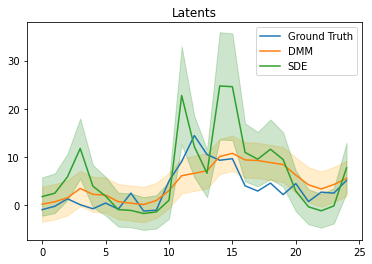

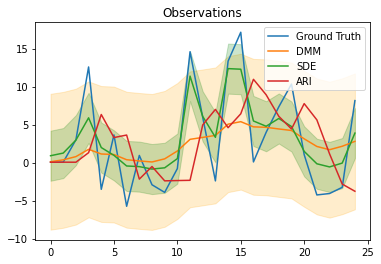

In [12]:
dataloaders = linear_gssm(n_train_samples=5000,
                          n_val_samples=512,
                          n_test_samples=512,
                          n_time_steps=25,
                          batch_size=512,
                          return_latents=True)
observations, latents = next(iter(dataloaders["test"]))
model_paths = ["../../models/dmm/fixed_emission/linear_synthetic.pth",
               "../../models/sde/fixed_emission/linear_synthetic.pth",
               "../../models/ARI/linear_synthetic.npy"]

dmm = DMMContinuousFixedEmission(st_net_hidden_dim=64, st_net_n_layers=1)
sde = SDEContinuousFixedEmission(10, 16)
ari = AutoRegressionIntegrated()
models = [dmm, sde, ari]
plot_synthetic_dataset(observations, latents, models, model_paths)

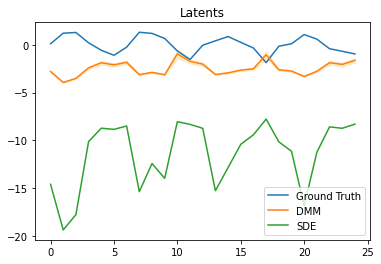

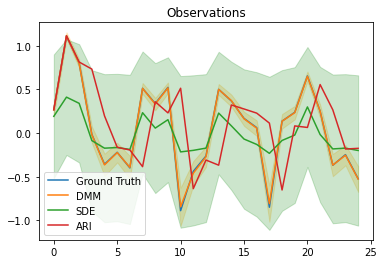

In [30]:
dataloaders = nonlinear_gssm2(n_train_samples=5000,
                          n_val_samples=512,
                          n_test_samples=512,
                          n_time_steps=25,
                          batch_size=512,
                          return_latents=True)
observations, latents = next(iter(dataloaders["test"]))
model_paths = ["../../models/dmm/nonlinear_synthetic2.pth",
               "../../models/sde/non_linear_synthetic2.pth",
               "../../models/ARI/non_linear_synthetic2.npy"]
dmm = DMMContinuous(256, 2, 1, 1)
sde = SDEContinuous(10, 16, 1, 1)
ari = AutoRegressionIntegrated()
models = [dmm, sde, ari]
plot_synthetic_dataset(observations, latents, models, model_paths)